In [5]:
import pandas as pd
import numpy as np


data = pd.read_csv('../dataset/regularite-mensuelle-tgv-aqst.csv')
df = pd.DataFrame(data)


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  8154 non-null   object 
 1   service                               8154 non-null   object 
 2   gare_depart                           8154 non-null   object 
 3   gare_arrivee                          8154 non-null   object 
 4   duree_moyenne                         8154 non-null   int64  
 5   nb_train_prevu                        8154 non-null   int64  
 6   nb_annulation                         8154 non-null   int64  
 7   commentaire_annulation                0 non-null      float64
 8   nb_train_depart_retard                8154 non-null   int64  
 9   retard_moyen_depart                   8154 non-null   float64
 10  retard_moyen_tous_trains_depart       8154 non-null   float64
 11  commentaire_retar

In [6]:

#On supprime les colonnes commentaires
#Potentiellement pas une bonne idée. Il faudrait d'abord supprimer les instances ayant un commentaire (cf case d'en dessous)

#df.drop(columns=['commentaire_annulation', 'commentaire_retards_depart', 'commentaires_retard_arrivee'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  8154 non-null   object 
 1   service                               8154 non-null   object 
 2   gare_depart                           8154 non-null   object 
 3   gare_arrivee                          8154 non-null   object 
 4   duree_moyenne                         8154 non-null   int64  
 5   nb_train_prevu                        8154 non-null   int64  
 6   nb_annulation                         8154 non-null   int64  
 7   commentaire_annulation                0 non-null      float64
 8   nb_train_depart_retard                8154 non-null   int64  
 9   retard_moyen_depart                   8154 non-null   float64
 10  retard_moyen_tous_trains_depart       8154 non-null   float64
 11  commentaire_retar

En lisant les commentaires pour les retards à l'arrivée, on se rend compte qu'ils viennent expliquer de potentiels retards plus importants que la normale dus à des évènements extraordinaires. 

Faut-il supprimer ces instances qui viennent polluer le dataset avec des évènements complètements imprévisibles ? Si oui, il faut d'abord supprimer les lignes avant de supprimer les 

Si je comprends bien, le retard_moyen, c'est le retard moyen des trains en retard et le retard_moyen_tous_trains, c'est le retard moyen de tous les trains, c'est à dire en incluant les trains qui ne sont pas en retard dans la balance. 

On peut donc diviser le problème en deux : soit on détermine le retard moyen de tous les trains sur un mois, soit on détermine le retard moyen attendu de tous les trains en retard sur un mois. 

Finalement il faut choisir si notre modèle prédit le retard d'un train à l'arrivée, au départ sachant qu'il y a un retard, au départ sans rien savoir, à l'arrivée en sachant qu'il y a un retard à l'arrivée, sachant qu'il y a un retard au départ en connaissant ou non la durée de ce retard. 

Pour la suite de l'analyse des données, on va s'intéresser au retard moyen tous trains confondus (ceux n'ayant pas de retard également).

Première proposition pour prédire ces retards : on met en entrée les 

Commençons par un comparaison entre deux lignes éloignées géographiquement, nous enchainerons ensuite par une comparaison entre deux lignes proches 
ie qui passent par les mêmes secteurs 

Pour chaque mois de 2018, on met les retards_moyens_tous_trains les uns à cotes des autres pour deux lignes

On veut voir si ce qui importe plus pour le retard c'est la ligne ou le moment de l'année et s'il y a une répétitivité dans le temps (des mois qui sont chaque année problématiques par exemple comme les mois d'hiver)

On veut vérifier s'il faut potentiellement créer une nouvelle caractéristique secteur (par exemple nord pour tous les tgvs qui prennent la ligne qui va 
vers le nord). ie ce qui compte le plus c'est pas la ligne mais les voies empruntées. 



In [20]:
#On prend deux lignes éloignées avec des temps de trajet comparables pour commencer : Paris est - strasbourg, paris nord - dunkerque

#Récupérons les instances qui correspondent à ces lignes

# Mettre en minuscule et supprimer les espaces dans la colonne
df['gare_depart'] = df['gare_depart'].str.lower()  # Mettre en minuscule
df['gare_arrivee'] = df['gare_arrivee'].str.lower()  # Mettre en minuscule
df['gare_depart'] = df['gare_depart'].str.replace(' ', '')  # Supprimer les espaces 
df['gare_arrivee'] = df['gare_arrivee'].str.replace(' ', '')  # Supprimer les espaces 

paris_stras = df[(df['gare_depart']== 'parisest') & (df['gare_arrivee'] == "strasbourg")]
paris_dunk = df[(df['gare_depart']== 'parisnord') & (df['gare_arrivee'] == "dunkerque")]


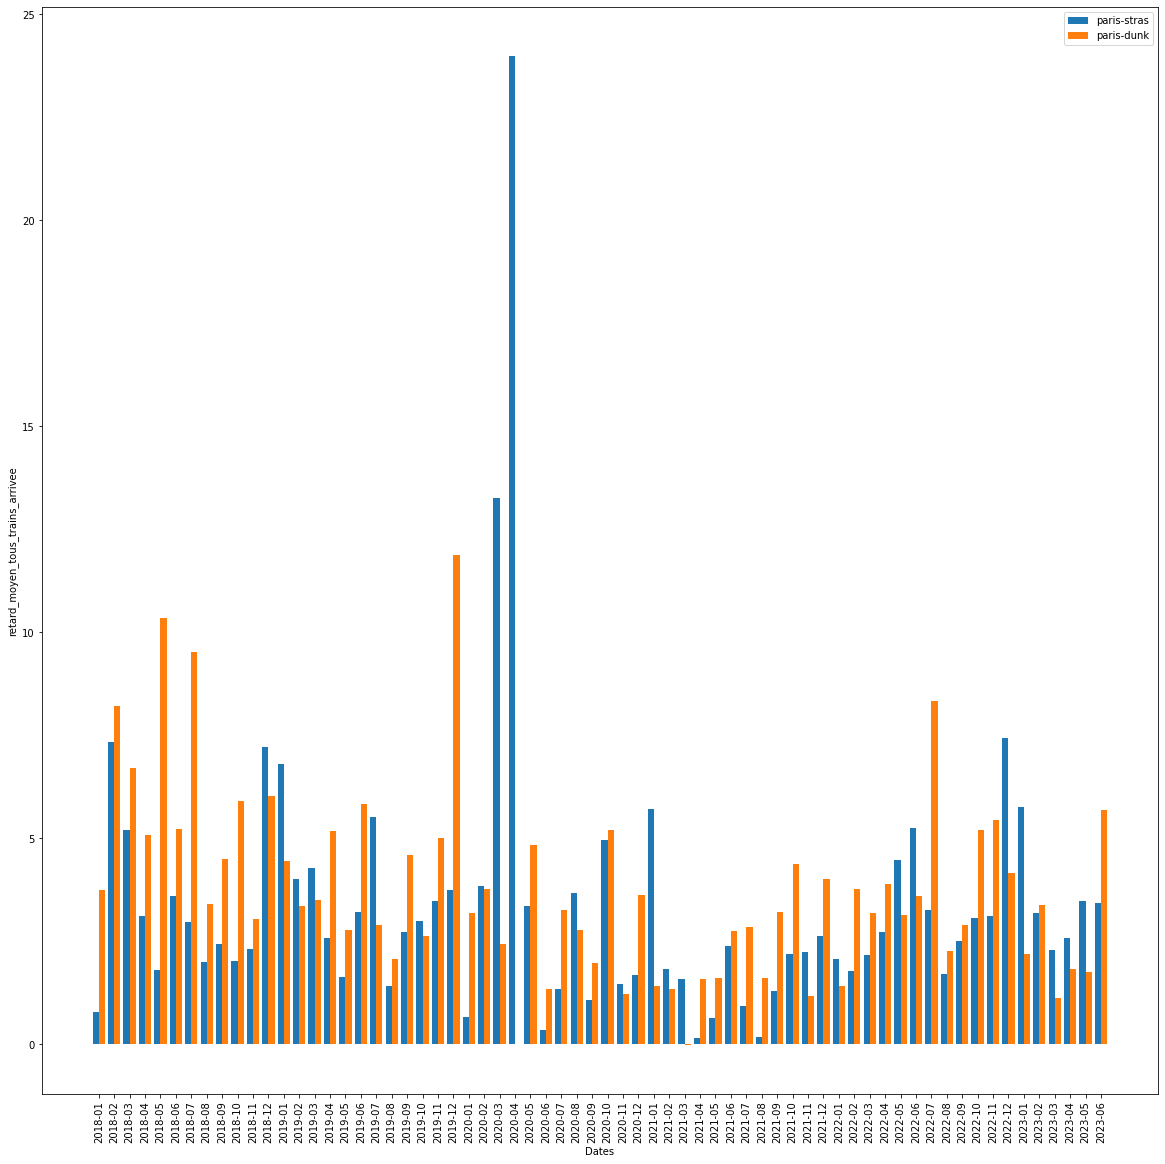

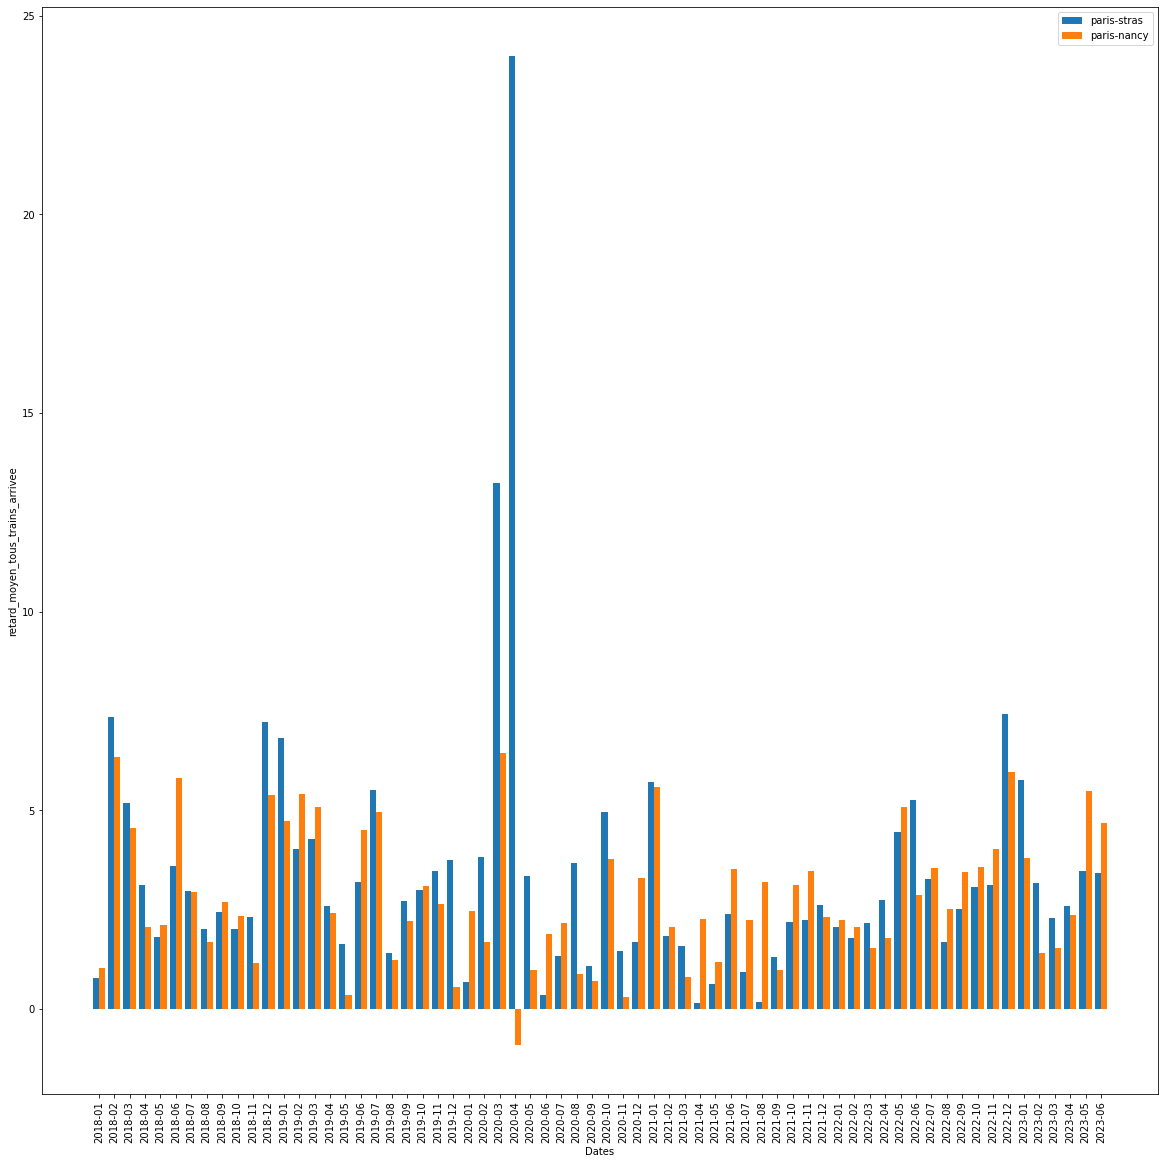

In [25]:
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 20))
# Créez un graphique à barres alternant entre les catégories
largeur_barre = 0.4
indices = range(len(paris_stras))
plt.bar(indices, paris_stras['retard_moyen_tous_trains_arrivee'], width=largeur_barre, label='paris-stras', align='center')
plt.bar([i + largeur_barre for i in indices], paris_dunk['retard_moyen_tous_trains_arrivee'], width=largeur_barre, label='paris-dunk', align='center')


# Ajoutez des étiquettes d'axe et une légende
plt.xlabel('Dates')
plt.ylabel('retard_moyen_tous_trains_arrivee')
plt.xticks([i + largeur_barre / 2 for i in indices], paris_stras['date'].unique(),  rotation='vertical')
plt.legend()

plt.show()

#Comparons avec deux lignes très proches géographiquement paris stras et paris nancy
paris_nancy = df[(df['gare_depart']== 'parisest') & (df['gare_arrivee'] == "nancy")] 

plt.figure(figsize=(20, 20))
# Créez un graphique à barres alternant entre les catégories
largeur_barre = 0.4
indices = range(len(paris_stras))
plt.bar(indices, paris_stras['retard_moyen_tous_trains_arrivee'], width=largeur_barre, label='paris-stras', align='center')
plt.bar([i + largeur_barre for i in indices], paris_nancy['retard_moyen_tous_trains_arrivee'], width=largeur_barre, label='paris-nancy', align='center')


# Ajoutez des étiquettes d'axe et une légende
plt.xlabel('Dates')
plt.ylabel('retard_moyen_tous_trains_arrivee')
plt.xticks([i + largeur_barre / 2 for i in indices], paris_stras['date'].unique(),  rotation='vertical')
plt.legend()

plt.show()




ON remarque que les retards sont plus proches pour les lignes qui empruntent les mêmes voies. On pourrait donc ajouter ce feature. 

Text(0, 0.5, 'différence des retards')

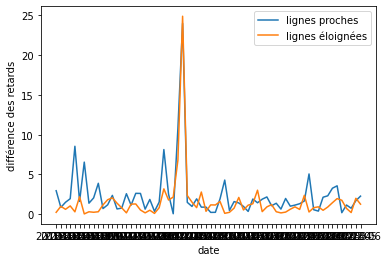

In [43]:
#Déterminons la proximité des retards entre deux lignes proches et deux lignes éloignées. 
#Il faut normaliser les données pour que ce soit comparable, à faire demain. 

dates = df['date']

diff_ps_pd = []

for date in dates : 
    ret1 = paris_stras[(paris_stras['date'] == date)]
    ret2 = paris_dunk[(paris_dunk['date'] == date)]
    diff_ps_pd.append(np.abs(ret1['retard_moyen_tous_trains_arrivee'].iloc[0] - ret2['retard_moyen_tous_trains_arrivee'].iloc[0]))

diff_ps_pn = [] 

for date in dates : 
    ret1 = paris_stras[(paris_stras['date'] == date)]
    ret2 = paris_nancy[(paris_nancy['date'] == date)]
    diff_ps_pn.append(np.abs(ret1['retard_moyen_tous_trains_arrivee'].iloc[0] - ret2['retard_moyen_tous_trains_arrivee'].iloc[0]))

plt.plot(dates,diff_ps_pd, label = 'lignes proches')
plt.plot(dates,diff_ps_pn, label = 'lignes éloignées')

plt.legend()
plt.xlabel('date')
plt.ylabel('différence des retards')
                      


On